In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
plt.style.use('../style/plots.mplstyle')
palette = ['#c0d9ffff', '#bfc1ffff', '#e3bfffff', '#ffbfe6ff', '#ffbfc4ff']

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure_weights_magnitude = os.path.join('svg', 'figure04c_weights_magnitude.svg')
path_figure_weights_correlation = os.path.join('svg', 'figure04d_weights_correlation.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_23_14)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [9]:
device = get_device()

num_layers = len(num_hidden)

norm_weights_parity = np.zeros((num_runs, num_layers))
norm_weights_value = np.zeros((num_runs, num_layers))
correlations = np.zeros((num_runs, num_layers))


seeds = list(results_task_switching.keys())
for j_seed, seed in enumerate(seeds):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                            num_hidden,
                            idxs_contexts,
                            device)
    model.load_state_dict(state_dict)
    for k_context in idxs_contexts:
        weights = model.layers[k_context].weight.detach().cpu().numpy()
        norm_parity, norm_value = np.linalg.norm(weights[:, -2:], axis=0)
        norm_weights_parity[j_seed, k_context] = norm_parity
        norm_weights_value[j_seed, k_context] = norm_value

        weights_parity = np.array(weights[:, -2])
        weights_value = np.array(weights[:, -1])
        correlations[j_seed, k_context] = np.corrcoef(weights_parity, weights_value)[0, 1]
            

Running on CPU.


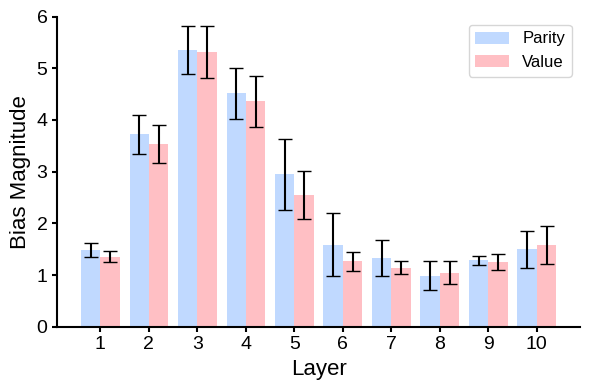

In [10]:
idxs_layers = np.arange(1, 11)

mean_parity = norm_weights_parity.mean(axis=0)
mean_value = norm_weights_value.mean(axis=0)
std_parity = norm_weights_parity.std(axis=0)
std_value = norm_weights_value.std(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.bar(idxs_layers-0.2, mean_parity, width=0.4, color=palette[0])
ax.bar(idxs_layers+0.2, mean_value, width=0.4, color=palette[-1])

ax.errorbar(idxs_layers-0.2, mean_parity, std_parity, color='k', linestyle='', capsize=5)
ax.errorbar(idxs_layers+0.2, mean_value, std_value, color='k', linestyle='', capsize=5)

ax.set_ylim(0, 6)
ax.set_xlabel('Layer')
ax.set_ylabel('Bias Magnitude')
ax.set_xticks(idxs_layers)

ax.legend(['Parity', 'Value'])

fig.tight_layout()
fig.savefig(path_figure_weights_magnitude, transparent=True)

plt.show()

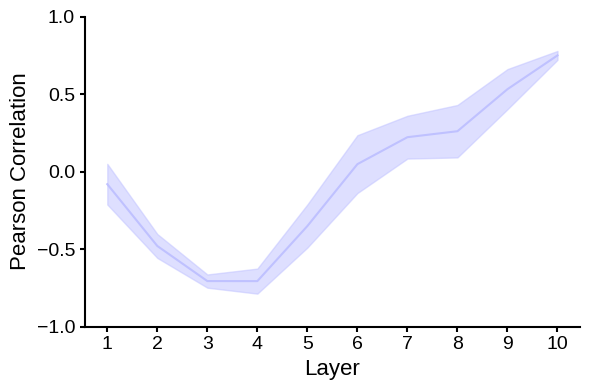

In [11]:
idxs_layers = range(1, 11)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

mean_corr = correlations.mean(axis=0)
std_corr = correlations.std(axis=0)

ax.plot(idxs_layers, mean_corr, color=palette[1])
ax.fill_between(idxs_layers, mean_corr-std_corr, mean_corr+std_corr, color=palette[1], alpha=.5)

ax.set_xlabel('Layer')
ax.set_ylabel('Pearson Correlation')
ax.set_xticks(idxs_layers)
ax.set_ylim(-1, 1)

fig.tight_layout()
fig.savefig(path_figure_weights_correlation, transparent=True)

plt.show()